**REINFORCE**算法在策略的参数空间中直观地通过梯度上升的方法逐步提高策略 $\pi_\theta$ 的性能。

$$ \nabla_\theta J(\pi_\theta)=\mathbb{E}_{\tau\sim\pi_\theta}\left[\sum_{t=0}^\mathrm{T}R_t\nabla_\theta\sum_{t^{\prime}=0}^t\log\pi_\theta(A_{t^{\prime}}|S_{t^{\prime}})\right]=\mathbb{E}_{\tau\sim\pi_\theta}\left[\sum_{t^{\prime}=0}^\mathrm{T}\nabla_\theta\log\pi_\theta(A_{t^{\prime}}|S_{t^{\prime}})\sum_{t=t^{\prime}}^\mathrm{T}R_t\right]\tag{1} $$

上述式子中 $\sum_{t=i}^{\mathrm{T}}R_t$ 可以看成是智能体在状态 $S_i$ 处选择动作 $A_i$，并在之后执行当前策略的情况下，从第 $i$ 步开始获得的累计奖励。

事实上，$\sum_{t=i}^{\mathrm{T}}R_t$ 也可以看成 $Q_i(A_i,S_i)$, 在第 $i$ 步状态$S_i$ 处采取动作 $A_i$, 并在之后执行当前策略的 $Q$ 值。

<font color=yellow>通过给不同的动作所对应的梯度根据它们的累计奖励赋予不同的权重，鼓励智能体选择那些累计奖励较高的动作 $A_{i}$。</font>

只要把上述式子中的 $T$ 替换成 $\infty$ 并赋予$R_t$ 以 $\gamma^t$ 的权重，扩展到折扣因子为 $\gamma$ 的无限范围。

$$\nabla J(\theta)=\mathbb{E}_{\tau\sim\pi_\theta}\left[\sum_{t'=0}^\infty\nabla_\theta\log\pi_\theta(A_{t'}|S_{t'})\gamma^{t'}\sum_{t=t'}^\infty\gamma^{t-t'}R_t\right]\tag{2}$$

- 优点
  - 简单直观
- 缺点
  - 对梯度的估计有较大的方差<sup><a href="#ref1">1</a></sup>。

> 1. <p name = "ref1">对于一个长度为 L 的轨迹，奖励 $R_t$ 的随机性可能对 L 呈指数级增长。</p>

In [1]:
from utils import evaluate_policy, str2bool, test_policy, PolicyNet, all_seed
from datetime import datetime
import gymnasium as gym
import os, shutil
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.utils.tensorboard import SummaryWriter
import random
import numpy as np
import copy
import math
from collections import deque

In [2]:
def get_args():
    # 创建命令行参数解析器
    parser = argparse.ArgumentParser()

    # 添加各种命令行参数
    parser.add_argument('--algo_name',default='REINFORCE_1',type=str,help="算法名")
    parser.add_argument('--dvc', type=str, default='cuda', help='运行设备: cuda 或 cpu')
    parser.add_argument('--env_name', type=str, default='CartPole-v1', help='环境名')
    parser.add_argument('--render_mode', type=str, default='rgb_array', help='环境渲染模式')
    parser.add_argument('--write', type=str2bool, default=True, help='使用SummaryWriter记录训练')
    parser.add_argument('--render', type=str2bool, default=False, help='是否渲染')
    parser.add_argument('--Loadmodel', type=str2bool, default=False, help='是否加载预训练模型')
    parser.add_argument('--ModelIdex', type=int, default=100000, help='要加载的模型索引')
    parser.add_argument('--deque_maxlen',default=30,type=int)

    parser.add_argument('--seed', type=int, default=1, help='随机种子')
    parser.add_argument('--Max_train_steps', type=int, default=5e7, help='最大训练步数')
    parser.add_argument('--save_interval', type=int, default=2e3, help='模型保存间隔，以步为单位')
    parser.add_argument('--eval_interval', type=int, default=1e3, help='模型评估间隔，以步为单位')
    parser.add_argument('--test_interval', type=int, default=2e3, help='视频保存间隔，以步为单位')

    parser.add_argument('--gamma', type=float, default=0.98, help='折扣因子')
    parser.add_argument('--K_epochs', type=int, default=1, help='网络更新次数')
    parser.add_argument('--net_width', type=int, default=256, help='隐藏网络宽度')
    parser.add_argument('--lr', type=float, default=5e-4, help='学习率')
    
    # 解析命令行参数
    args = parser.parse_args([])
    args = {**vars(args)}  # 转换成字典类型    
    
    return args

In [3]:
def print_args(args):
    ## 打印超参数
    print("超参数")
    print(''.join(['=']*80))
    tplt = "{:^20}\t{:^20}\t{:^20}"
    print(tplt.format("Name", "Value", "Type"))
    for k,v in args.items():
        print(tplt.format(k,v,str(type(v))))   
    print(''.join(['=']*80))  

In [4]:
class REINFORCE:
    def __init__(self, kwargs):
        self.__dict__.update(kwargs)
        self.policy_net = PolicyNet(self.state_dim, self.net_width, self.action_dim).to(self.dvc)
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=self.lr)  # 使用Adam优化器

    def choose_action(self, state):  # 根据动作概率分布随机采样
        state = torch.tensor([state], dtype=torch.float).to(self.dvc)
        probs = self.policy_net(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()
    
    def discount_and_norm_rewards(self, reward_list):
        """
        计算折扣回报并对其进行归一化处理。

        返回:
            np.ndarray: 归一化后的折扣回报数组
        """
        # 初始化折扣回报数组
        G_list = np.zeros_like(reward_list)
        
        # 计算折扣回报（G值）
        G = 0
        for i in reversed(range(len(reward_list))):  # 从最后一步算起
            G = G * self.gamma + reward_list[i]
            G_list[i] = G

        # 归一化处理（均值为0，标准差为1）
        G_list -= np.mean(G_list)
        G_list /= np.std(G_list)

        # 返回归一化后的折扣回报数组
        return G_list

    def update(self, transition_dict):
        reward_list = transition_dict['rewards']
        state_list = transition_dict['states']
        action_list = transition_dict['actions']

        G_list = self.discount_and_norm_rewards(reward_list)
        G_list = torch.tensor(G_list, dtype=torch.float).to(self.dvc)

        self.optimizer.zero_grad()
        for i in reversed(range(len(reward_list))):  # 从最后一步算起
            state = torch.tensor([state_list[i]], dtype=torch.float).to(self.dvc)
            action = torch.tensor([action_list[i]]).view(-1, 1).to(self.dvc)
            log_prob = torch.log(self.policy_net(state).gather(1, action))
            loss = -log_prob * G_list[i]  # 每一步的损失函数
            loss.backward()  # 反向传播计算梯度
        self.optimizer.step()  # 梯度下降

        return loss.item()

    def save(self, episode):
        """
        保存当前训练模型的Actor和Critic参数到文件

        参数:
        - episode: 当前训练的episode数，用于在文件名中标识不同的保存点
        """
        model_path = f"model/{cfg['path']}"
        # 检查是否存在'model'文件夹，如果不存在则创建
        try:
            os.makedirs(model_path)
        except FileExistsError:
            pass

        torch.save(self.policy_net.state_dict(), f"{model_path}/ppo_critic{episode}.pth")


    def load(self, episode):
        """
        从文件加载之前保存的Actor和Critic参数

        参数:
        - episode: 要加载的保存点的episode数
        """

        self.policy_net.load_state_dict(torch.load("./model/policy_net{}.pth".format(episode)))

In [5]:
def env_agent_config(cfg, path):
    """
    配置环境和代理

    参数:
    - cfg: 包含配置信息的字典
    - path: 模型保存路径

    返回:
    - env: Gym 环境
    - agent: PPO 代理

    说明:
    1. 创建指定环境并设置渲染模式。
    2. 如果配置中设置了种子，则为环境设置种子。
    3. 获取环境的状态空间维度和动作空间维度。
    4. 更新配置字典中的状态维度和动作维度。
    5. 创建 PPO 代理。

    注意:
    - PPO 代理的创建依赖于配置信息和模型保存路径。
    """
    env = gym.make(cfg['env_name'], render_mode=cfg['render_mode'])  # 1. 创建环境
    eval_env = gym.make(cfg['env_name'], render_mode=cfg['render_mode'])
    if cfg['seed'] != 0:
        all_seed(env, seed=cfg['seed'])  # 2. 如果配置中设置了种子，则为环境设置种子

    n_states = env.observation_space.shape[0]  # 3. 获取状态空间维度
    n_actions = env.action_space.n  # 获取动作空间维度
    max_e_steps = env._max_episode_steps  # 最大步数
    print(f"状态空间维度：{n_states}，动作空间维度：{n_actions}，最大步数：{max_e_steps}")
    cfg.update({"state_dim": n_states, "action_dim": n_actions, "max_e_steps": max_e_steps})  # 4. 更新n_states和n_actions到cfg参数中

    agent = REINFORCE(cfg)  # 5. 创建 PPO 代理
    return env, eval_env, agent

In [6]:
# 获取参数
cfg = get_args()

path = f"device:{cfg['dvc']}/{cfg['env_name']}/seed:{cfg['seed']}/{cfg['algo_name']}/net_width-{cfg['net_width']}-gamma-{cfg['gamma']}-K_epochs-{cfg['K_epochs']}-lr-{cfg['lr']}"
cfg.update({"path":path}) # 更新n_states和n_actions到cfg参数中

base_dir = f"log/{cfg['path']}"

env, eval_env, agent = env_agent_config(cfg, path)

cfg.update({"mean_break":cfg['max_e_steps'] * 0.99})

print_args(cfg)

状态空间维度：4，动作空间维度：2，最大步数：500
超参数
        Name        	       Value        	        Type        
     algo_name      	    REINFORCE_1     	   <class 'str'>    
        dvc         	        cuda        	   <class 'str'>    
      env_name      	    CartPole-v1     	   <class 'str'>    
    render_mode     	     rgb_array      	   <class 'str'>    
       write        	         1          	   <class 'bool'>   
       render       	         0          	   <class 'bool'>   
     Loadmodel      	         0          	   <class 'bool'>   
     ModelIdex      	       100000       	   <class 'int'>    
    deque_maxlen    	         30         	   <class 'int'>    
        seed        	         1          	   <class 'int'>    
  Max_train_steps   	     50000000.0     	  <class 'float'>   
   save_interval    	       2000.0       	  <class 'float'>   
   eval_interval    	       1000.0       	  <class 'float'>   
   test_interval    	       2000.0       	  <class 'float'>   
       gamma        	   

In [7]:
def train(cfg):
    print("开始训练")
    env_seed = cfg['seed']
    # 使用TensorBoard记录训练曲线
    if cfg['write']:
        writepath = 'runs/{}'.format(cfg['path']) # 构建TensorBoard日志路径
        if os.path.exists(writepath): shutil.rmtree(writepath)  # 如果路径已存在，则删除该路径及其内容
        writer = SummaryWriter(log_dir=writepath)  # 创建TensorBoard写入器，指定日志路径

    # 如果指定了加载模型的选项，则加载模型
    if cfg['Loadmodel']:
        print("加载模型")
        agent.load(cfg['ModelIdex'])

    # 如果选择渲染模式
    if cfg['render']:
        while True:
            # 在环境中评估智能体的性能，并输出奖励
            ep_r = evaluate_policy(env, agent, turns=1)
            print('Env: ', cfg['env_name'],' Episode Reward: ', {ep_r})
    else:
        total_steps = 0  # 记录训练步数
        test_steps = 0  # 记录测试步数
        scores_deque = deque(maxlen=cfg['deque_maxlen'])

        # 在达到最大训练步数前一直进行训练
        while total_steps < cfg['Max_train_steps']:
            episode_return = 0  # 记录每个episode的奖励
            transition_dict = {
                'states': [],
                'actions': [],
                'next_states': [],
                'rewards': [],
                'dones': []
                }
            
            s, info = env.reset(seed=env_seed)  # 重置环境，使用环境种子
            env_seed += 1
            done = False

            # 与环境进行交互并训练
            while not done:
                # 选择动作和动作对应的对数概率
                a = agent.choose_action(s)  # 在训练时使用随机动作
                s_next, r, dw, tr, info = env.step(a)  # 执行动作并获取下一个状态、奖励以及其他信息
                done = (dw or tr)  # 如果游戏结束（死亡或胜利），则done为True

                # 存储当前的转移数据
                transition_dict['states'].append(s)
                transition_dict['actions'].append(a)
                transition_dict['next_states'].append(s_next)
                transition_dict['rewards'].append(r)
                transition_dict['dones'].append(done)
                s = s_next
                episode_return += r  # 累计奖励
                
            total_steps += 1
            
            scores_deque.append(episode_return)

            # 更新智能体的策略
            for _ in range(cfg['K_epochs']):
                loss = agent.update(transition_dict)  # 执行PPO算法的训练步骤
            if cfg['write']:
                writer.add_scalar('Loss', loss, global_step=total_steps)
                writer.add_scalar('Episode_Reward', episode_return, global_step=total_steps)
                writer.add_scalar('Episode_Average_Reward', np.mean(scores_deque), global_step=total_steps)

            # 如果达到记录和日志的时间
            if total_steps % cfg['eval_interval'] == 0:
                # 在评估环境中评估智能体，并输出平均奖励
                score = evaluate_policy(eval_env, agent, total_steps, turns=3)  # 对策略进行3次评估，取平均值
                scores_deque.append(score)
                test_steps += 1
                if cfg['write']:
                    writer.add_scalar('Score_ep', score, global_step=total_steps)  # 将评估得分记录到TensorBoard
                    writer.add_scalar('Score_Average', np.mean(scores_deque), global_step=total_steps)
                print('EnvName:', cfg['env_name'], 'seed:', cfg['seed'],
                        'steps: {}k'.format(int(total_steps / 1000)), 'score:', score)
                    
            if total_steps % cfg['test_interval'] == 0:
                test_policy(eval_env, agent, total_steps, turns=1, path=cfg['path'], cfg=cfg)

            # 如果达到保存模型的时间
            if total_steps % cfg['save_interval'] == 0:
                print("保存模型")
                agent.save(total_steps)  # 保存模型

            if (np.mean(scores_deque) >= cfg['mean_break']) and (len(scores_deque) >= cfg['deque_maxlen']):
                print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(total_steps, np.mean(scores_deque)))
                test_policy(eval_env, agent, total_steps, turns=1, path=cfg['path'], cfg=cfg)
                print("保存模型")
                agent.save(total_steps)
                env.close()
                eval_env.close()
                return

        env.close()
        eval_env.close()

开始训练


/tmp/ipykernel_13632/1776135542.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  state = torch.tensor([state], dtype=torch.float).to(self.dvc)


Environment solved in 460 episodes!	Average Score: 500.00
保存视频
保存模型


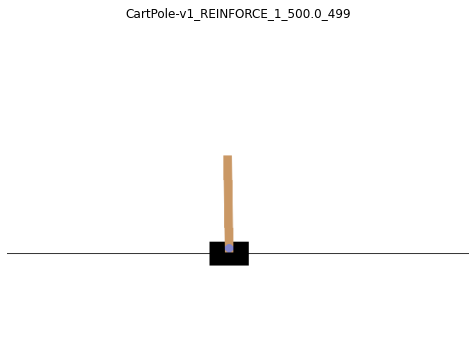

In [8]:
train(cfg)